In [93]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# import models from sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, GridSearchCV, StratifiedShuffleSplit, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [94]:
# Classification problem - predicting through variables: C : {}, D: {} for outcome Survived : [0,1]
# 0 = , 1 = 
df = pd.read_csv("/kaggle/input/titanic/train.csv")
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")
example_sub = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")

In [95]:
df.head()

# recall - survived = 1, dead = 0


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [96]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [97]:
X = df.drop("Survived", axis=1)
Y = df["Survived"]

from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y,test_size = .3, random_state=0)

Y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

# Data Overview

####  Variable Overview
* Categorical:
    *     Nominal:
            - Cabin 
            - Embarked: C = Cherbourg, Q = Queenstown, S = Southampton
    *     Dichotomous
            - Sex: Male, Female
    *     Ordinal
            - PClass: 1 = Upper, 2 = Middle, 3 = Lower

* Discrete
    - Passenger ID(Unique identifing # for each passenger)
    - SibSp
    - Parch
    - Survived (Our outcome or dependent variable)
* Continous
    - Age
    - Fare   
* Text / ID Variables
    - Ticket Num
    - Passenger Name

In [98]:
X_train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
857,858,1,"Daly, Mr. Peter Denis",male,51.0,0,0,113055,26.5500,E17,S
52,53,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
386,387,3,"Goodwin, Master. Sidney Leonard",male,1.0,5,2,CA 2144,46.9000,NaN,S
124,125,1,"White, Mr. Percival Wayland",male,54.0,0,1,35281,77.2875,D26,S
578,579,3,"Caram, Mrs. Joseph (Maria Elias)",female,NaN,1,0,2689,14.4583,NaN,C


#### Survival by Passenger Sex

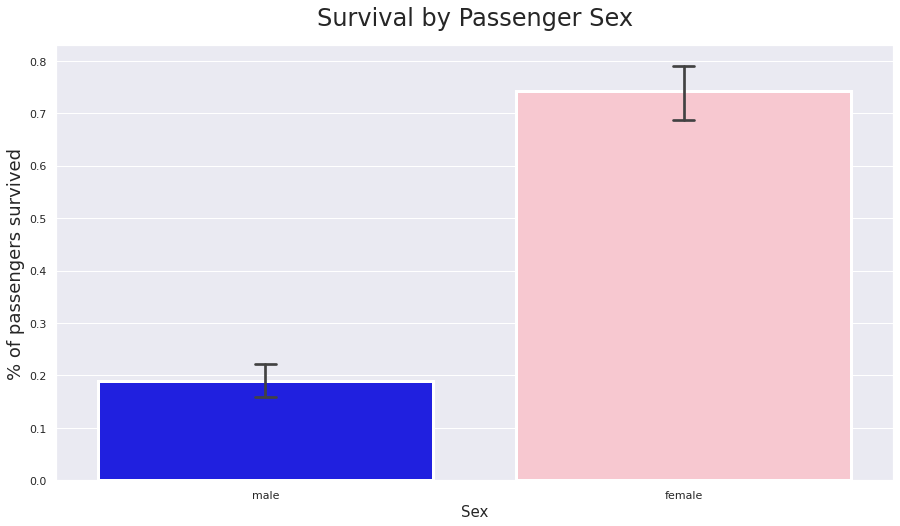

In [99]:
palette = {'male':"blue", 'female':"Pink"}
sns.set(style="darkgrid")
plt.subplots(figsize = (15,8))
ax = sns.barplot(x = "Sex", 
                 y = "Survived", 
                 data=df, 
                 palette = palette,
                 linewidth=3,
                 order = ['male', 'female'],
                 capsize = .05,

                )

plt.title("Survival by Passenger Sex", fontsize = 24,loc = 'center', pad = 20)
plt.ylabel("% of passengers survived", fontsize = 18, )
plt.xlabel("Sex",fontsize = 15);



#### More data visualization to come 

## Feature Engineering

#### Label Encoding the Categorical Data 

In [100]:
categorical_feats = ['Sex', 'Cabin', 'Embarked', 'Pclass']
id_feats = ['Ticket', 'Name', 'PassengerId']
non_numeric_feats = categorical_feats + id_feats


for category in categorical_feats:
    encoder = LabelEncoder()
    encoder.fit(X[category])
    X_train[str('Enc ' + category)] = encoder.transform(X_train[category])
    X_valid[str('Enc ' + category)] = encoder.transform(X_valid[category])

X_train = X_train.reset_index(drop = True)
X_valid = X_valid.reset_index(drop = True)

X_train_numeric = X_train.drop(columns = non_numeric_feats).fillna(value = 0)
X_valid_numeric = X_valid.drop(columns = non_numeric_feats).fillna(value = 0)

Y_train = Y_train.reset_index(drop = True)
Y_valid = Y_valid.reset_index(drop = True)

print(Y_valid)

0      0
1      0
2      0
3      1
4      1
      ..
263    0
264    0
265    0
266    1
267    0
Name: Survived, Length: 268, dtype: int64


In [101]:
### Feature Scaling
from sklearn.preprocessing import StandardScaler
st_scale = StandardScaler()

X_train_numeric = st_scale.fit_transform(X_train_numeric)
X_valid_numeric = st_scale.transform(X_valid_numeric)

## Model Building

### Comparing Several Classification Models

In [102]:
classifiers_dict = {
    "KNN": KNeighborsClassifier(), 
    "LR": LogisticRegression(max_iter=1000), 
    "DT": DecisionTreeClassifier(),
    "RF": RandomForestClassifier(),
    "SVM": SVC(),
    "MLP": MLPClassifier(max_iter=1000),
    "XGB": XGBClassifier(),
    "LGBM": LGBMClassifier(),
    "GNB": GaussianNB(),
    
}

In [108]:
#### classification model function using models above
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


def class_model(model_ticker, model_init):
    model = model_init
    model.fit(X_train_numeric, Y_train)
    preds = model.predict(X_valid_numeric)
    print("Confusion Matrix for " + model_ticker + ": \n")
    print(pd.DataFrame(confusion_matrix(Y_valid,preds),columns=["Predicted Not-Survived", "Predicted Survived"],index=["Not-Survived","Survived"] ))

    


Confusion Matrix for Log Reg: 

              Predicted Not-Survived  Predicted Survived
Not-Survived                     141                  27
Survived                          26                  74


In [ ]:
class_model("Log Reg", LogisticRegression(max_iter=1000))
for model_ticker, model_init in classifiers_dict:
    

### Bagging Classifier 

In [ ]:
### Bagging approach w. grid search 

from sklearn.ensemble import BaggingClassifier
n_estimators = [10,30,50,70,80,150,160, 170,175,180,185];
cv = StratifiedShuffleSplit(n_splits=10, test_size=.30, random_state=15)

parameters = {'n_estimators':n_estimators,}
grid = GridSearchCV(BaggingClassifier(base_estimator= None, bootstrap_features=False), param_grid=parameters, cv=cv,n_jobs = -1)
grid.fit(X,y)

In [ ]:
print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)
bagging_grid = grid.best_estimator_
bagging_grid.score(X,y)

### AdaBoostClassifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
n_estimators = [100,140,145,150,160, 170,175,180,185];
cv = StratifiedShuffleSplit(n_splits=10, test_size=.30, random_state=15)
learning_r = [0.1,1,0.01,0.5]

parameters = {'n_estimators':n_estimators,
              'learning_rate':learning_r
              
        }
grid = GridSearchCV(AdaBoostClassifier(base_estimator= None, ## If None, then the base estimator is a decision tree.
                                     ),
                                 param_grid=parameters,
                                 cv=cv,
                                 n_jobs = -1)
grid.fit(X,y) 

In [ ]:
print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)
adaBoost_grid = grid.best_estimator_
adaBoost_grid.score(X,y)

### Voting Classifier

In [ ]:
from sklearn.ensemble import VotingClassifier

## *** Update names here according to models tested above *** ## 
voting_classifier = VotingClassifier(estimators=[
    ('lr', logreg_grid),
    ('svc', svm_grid),
    ('random_forest', rf_grid),
    ('gradient_boosting', gradient_boost),
    ('decision_tree_grid',dectree_grid),
    ('knn_classifier', knn_grid),
    ('XGB_Classifier', XGBClassifier),
    ('bagging_classifier', bagging_grid),
    ('gaussian_classifier',gaussian),
    ('gaussian_process_classifier', GaussianProcessClassifier)
],voting='hard')

voting_classifier = voting_classifier.fit(X,y)

### Final Submission

In [ ]:
all_models = [logreg_grid,
              knn_grid, 
              knn_ran_grid,
              svm_grid,
              dectree_grid,
              rf_grid,
              bagging_grid,
              adaBoost_grid,
              voting_classifier]

c = {}
for i in all_models:
    a = i.predict(X_test)
    b = accuracy_score(a, y_test)
    c[i] = b
    

In [ ]:
test_prediction = (max(c, key=c.get)).predict(test)
submission = pd.DataFrame({
        "PassengerId": passengerid,
        "Survived": test_prediction
    })

submission.PassengerId = submission.PassengerId.astype(int)
submission.Survived = submission.Survived.astype(int)

submission.to_csv("titanic1_submission.csv", index=False)